# Model Training

In [1]:
import networkx as nx
from networkx.algorithms.link_prediction import jaccard_coefficient

import random

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report



from concurrent.futures import ProcessPoolExecutor

import copy

import re

In [2]:
global_random_state = 26

# Import normalized data
with open('03-normalized-data/predictors.pkl', 'rb') as f:
    predictors = pickle.load(f)

baseline_p = predictors[5] # Remove the baseline predictor from the predictors

predictors = predictors[:5]


# Save data for later use



# Import edgenonedge data
with open('04-edgenonedge-data/edgenonedge_data.pkl', 'rb') as f:
    edgenonedge_data = pickle.load(f)

# Save data 
with open('05-edge-metadata/edge_metadata.pkl', 'rb') as f:
    full_edge_metadata = pickle.load(f)


    

predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product']



In [3]:
p = 0
g = 0
e = 5
print('Sample edge prediction score:', predictors[p][g][e])

Sample edge prediction score: [8.06526378e-11]


# Create Features and Labels

In [4]:
# LABELS
# The labels will be the index of the 'most correct' predictor
# If the edge actually exists, the 'most correct' predictor is the one with the highest score.
# If it doesn't exist, the 'most correct' predictor has the lowest score.

import numpy as np

def compute_mces_with_sampling(edgenonedge_data, predictors, non_edge_sample_prob=1):
    """
    Compute the most correct estimator (MCE) for each graph, with optional sampling for non-edges.

    Parameters:
        edgenonedge_data (list of np.ndarray): Binary labels indicating real edges (1) and non-edges (0).
        predictors (list of list of np.ndarray): Predictor scores for each graph.
        non_edge_sample_prob (float): Probability of sampling a non-edge (default is 1.0, no subsampling).

    Returns:
        mces (list of np.ndarray): Most correct estimator indices for each graph.
    """
    mces = []  # Place to store the most correct estimators for each graph
    edges_kept = []

    for g in range(len(edgenonedge_data)):  # Iterate over each graph
        curr_g_predictions = []

        # Collect predictions for all predictors for the current graph
        for p in predictors:
            curr_g_predictions.append(p[g])
        curr_g_predictions = np.array(curr_g_predictions)

        # Find the most correct predictor for each edge
        most_correct_estimator = []
        edge_is_real = edgenonedge_data[g]
        edges_kept_g = []

        for i in range(curr_g_predictions.shape[1]):  # Iterate over each edge (column index)
            if edge_is_real[i]:  # If the edge exists
                index = np.argmax(curr_g_predictions[:, i])  # Predictor with the maximum value
                most_correct_estimator.append(index)
                edges_kept_g.append(1)
            else:  # If the edge does not exist (non-edge)
                if np.random.rand() < non_edge_sample_prob:  # Sample based on probability
                    index = np.argmin(curr_g_predictions[:, i])  # Predictor with the minimum value
                    most_correct_estimator.append(index)
                    edges_kept_g.append(1)
                else:
                    edges_kept_g.append(0)

        # Convert the result to a NumPy array
        most_correct_estimator = np.array(most_correct_estimator).reshape(-1, 1)
        edges_kept_g = np.array(edges_kept_g).reshape(-1, 1)

        # Append to the global list
        mces.append(most_correct_estimator)
        edges_kept.append(edges_kept_g)

    return mces, edges_kept


# Example Usage
non_edge_sample_prob = 1  # Chance to include a non-edge
mces, edges_kept = compute_mces_with_sampling(edgenonedge_data, predictors, non_edge_sample_prob)

print(edges_kept)



[array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]]), array([[1],
       [1],
       [1],
       ...,
     

In [5]:
# Remove edges which were not kept during mces computation

print('before updating metadata...', full_edge_metadata[0].shape)

def update_edge_metadata(edge_metadata, edges_kept):
    updated_edge_metadata = []
    for g, m in zip(edge_metadata, edges_kept):  # Iterate over each graph's metatdata
        mask = m.flatten()
        mask = mask.astype(bool)
        masked_data = g[mask]
        updated_edge_metadata.append(masked_data)

    return updated_edge_metadata

edge_metadata = update_edge_metadata(full_edge_metadata, edges_kept)

print('after updating metadata...', edge_metadata[0].shape)

before updating metadata... (382060, 16)
after updating metadata... (382060, 16)


In [6]:
import numpy as np
from sklearn.utils import shuffle  # Utility for shuffling data


def custom_train_test_split(edge_metadata, mces, test_size=0.2, random_state=None):
   """
   Custom function to split graph-level data into training and testing sets.


   Parameters:
       edge_metadata (list of np.ndarray): Feature data for each graph.
       mces (list of np.ndarray): Label data for each graph.
       test_size (float): Fraction of the data to be used for testing.
       random_state (int, optional): Random seed for reproducibility.


   Returns:
       X_train_combined (np.ndarray): Combined and shuffled training data for all graphs.
       y_train_combined (np.ndarray): Combined and shuffled training labels for all graphs.
       X_test (list of np.ndarray): List of testing data for each graph.
       y_test (list of np.ndarray): List of testing labels for each graph.
   """
   # Set random seed for reproducibility
   if random_state is not None:
       np.random.seed(random_state)


   # Determine the number of graphs
   num_graphs = len(edge_metadata)


   # Create a shuffled list of graph indices
   shuffled_indices = np.random.permutation(num_graphs)


   # Split indices into training and testing
   split_idx = int((1 - test_size) * num_graphs)
   train_indices = shuffled_indices[:split_idx]
   test_indices = shuffled_indices[split_idx:]


   # Split the data
   X_train = [edge_metadata[i] for i in train_indices]
   y_train = [mces[i] for i in train_indices]
   X_test = [edge_metadata[i] for i in test_indices]
   y_test = [mces[i] for i in test_indices]


   # Combine training data into single arrays
   X_train_combined = np.vstack(X_train)
   y_train_combined = np.vstack(y_train)


   # Shuffle the combined training data
   X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=random_state)


   return X_train_combined, y_train_combined, X_test, y_test


X_train, y_train, X_test, y_test =  custom_train_test_split(edge_metadata, mces, test_size=0.2, random_state=global_random_state)

# Run Models

In [7]:
def create_training_data(edgenonedge_data, predictors, non_edge_sample_prob, full_edge_metadata, test_size=0.2, random_state=None):

    mces, edges_kept = compute_mces_with_sampling(
        edgenonedge_data, 
        predictors, 
        non_edge_sample_prob
        )
    
    # Update edge_metadata, remove 
    edge_metadata = update_edge_metadata(full_edge_metadata, edges_kept)

    # Split data into train test groups in the same way as before...
    X_train_combined, y_train_combined, X_test, y_test =  custom_train_test_split(
        edge_metadata, 
        mces,
        test_size, 
        random_state
        )    
    
    # Return just the training data
    return X_train_combined, y_train_combined


non_edge_sample_prob = 0.00001
X_train_reduced, y_train_reduced = create_training_data(edgenonedge_data, predictors, non_edge_sample_prob, full_edge_metadata, test_size=0.2, random_state=global_random_state)

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


def train_models(X_train_reduced, y_train_reduced):
    # Initialize the classifiers
    nb = GaussianNB()
    svm = SVC(kernel='rbf', probability=True, random_state=42)  # SVM with RBF kernel
    rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest with 100 trees

    # Train Naive Bayes
    nb.fit(X_train_reduced, y_train_reduced.ravel())
    print("Naive Bayes training complete.")

    # Train SVM
    svm.fit(X_train_reduced, y_train_reduced.ravel())
    print("SVM training complete.")

    # Train Random Forest
    rf.fit(X_train_reduced, y_train_reduced.ravel())
    print("Random Forest training complete.")

    return nb, svm, rf


nb, svm, rf = train_models(X_train_reduced, y_train_reduced)



Naive Bayes training complete.
SVM training complete.
Random Forest training complete.


In [9]:


# # Recreate the necessary variables from custom_train_test_split
# test_size = 0.2
# num_graphs = len(edge_metadata)
# np.random.seed(global_random_state)  # Set random seed for reproducibility
# shuffled_indices = np.random.permutation(num_graphs)  # Shuffle the graph indices
# split_idx = int((1 - test_size) * num_graphs)  # Calculate the split index
# train_indices = shuffled_indices[:split_idx]  # Training graph indices
# test_indices = shuffled_indices[split_idx:]  # Testing graph indices
# print('test_indices', test_indices)

# # Sanity Check: Model Performance Based on Predictor Scores
# import numpy as np

# # Select a test graph index
# g = 0  # Index of the test graph in X_test
# test_graph_index = test_indices[g]  # Actual graph index in the original dataset

# # Extract data for the test graph
# X_test_graph = X_test[g]  # Edge metadata for the graph
# y_test_graph = y_test[g]  # Model's "best predictor" predictions for the graph
# edge_is_real_full = edgenonedge_data[test_graph_index]  # Real edge labels for the full graph
# edge_scores = np.array([predictor[test_graph_index] for predictor in predictors])  # Predictor scores


# # Model Predictions: Which predictor to use for each edge
# y_pred_nb = nb.predict(X_test_graph)  # Predicted best predictor for each edge
# y_pred_svm = svm.predict(X_test_graph)  # Predicted best predictor for each edge
# y_pred_rf = rf.predict(X_test_graph)  # Predicted best predictor for each edge

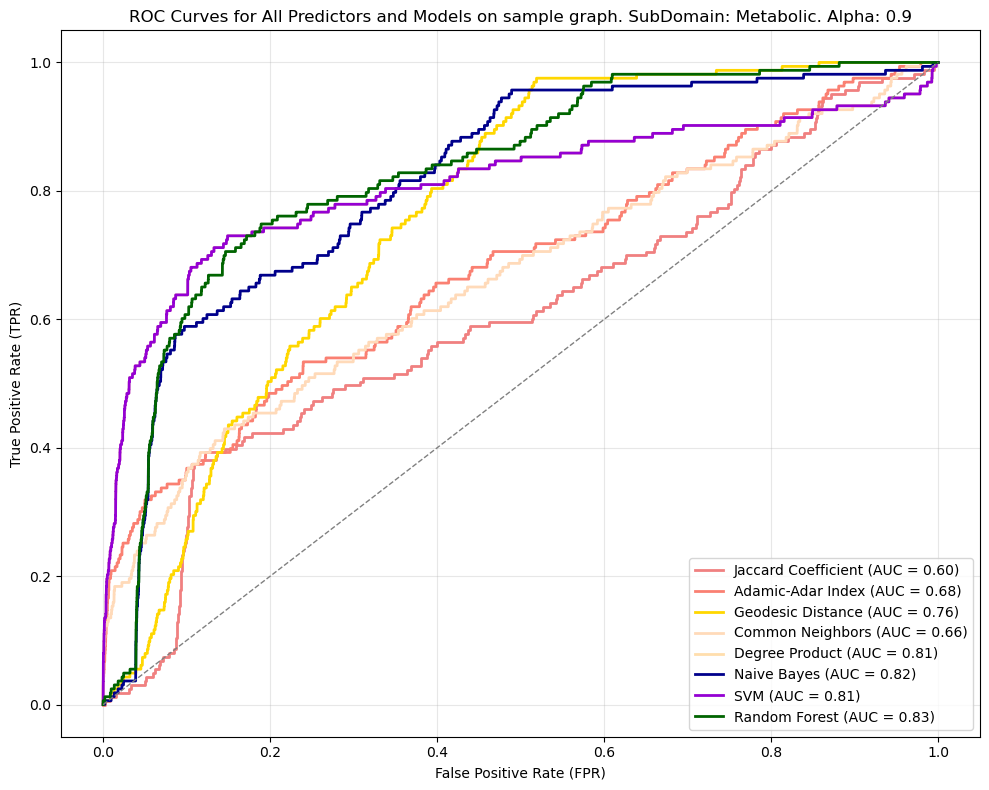

In [10]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os


def display_ROC(nb, svm, rf, edge_metadata, global_random_state, X_test, y_test, edgenonedge_data, predictors, subDomain, alpha):

    # Recreate the necessary variables from custom_train_test_split
    test_size = 0.2
    num_graphs = len(edge_metadata)
    np.random.seed(global_random_state)  # Set random seed for reproducibility
    shuffled_indices = np.random.permutation(num_graphs)  # Shuffle the graph indices
    split_idx = int((1 - test_size) * num_graphs)  # Calculate the split index
    train_indices = shuffled_indices[:split_idx]  # Training graph indices
    test_indices = shuffled_indices[split_idx:]  # Testing graph indices




    g = 0  # Index of the test graph in X_test, effectively a random graph
    test_graph_index = test_indices[g]  # Actual graph index in the original dataset



    # Extract data for the test graph
    X_test_graph = X_test[g]  # Edge metadata for the graph
    y_test_graph = y_test[g]  # Model's "best predictor" predictions for the graph
    edge_is_real_full = edgenonedge_data[test_graph_index]  # Real edge labels for the full graph
    edge_scores = np.array([predictor[test_graph_index] for predictor in predictors])  # Predictor scores

    # Model Predictions: Which predictor to use for each edge
    y_pred_nb = nb.predict(X_test_graph)  # Predicted best predictor for each edge
    y_pred_svm = svm.predict(X_test_graph)  # Predicted best predictor for each edge
    y_pred_rf = rf.predict(X_test_graph)  # Predicted best predictor for each edge

    # Subsample edge_is_real to match the subsampling in X_test_graph
    edge_is_real = edge_is_real_full[:X_test_graph.shape[0]].flatten()  # Match size of X_test_graph

    model_edge_scores_nb = np.array([
        edge_scores[predictor_idx, edge_idx]
        for edge_idx, predictor_idx in enumerate(y_pred_nb)
    ])

    model_edge_scores_svm = np.array([
        edge_scores[predictor_idx, edge_idx]
        for edge_idx, predictor_idx in enumerate(y_pred_svm)
    ])

    model_edge_scores_rf = np.array([
        edge_scores[predictor_idx, edge_idx]
        for edge_idx, predictor_idx in enumerate(y_pred_rf)
    ])

    # Compute ROC curves and AUCs for all predictors and the model
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'black']
    predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                    'Common Neighbors', 'Degree Product', 'Model']

    # Debugging the number of iterations
    flattened_edge_scores = edge_scores.reshape(edge_scores.shape[0], -1)

    # Stack the predictor and model scores
    stacked_scores = np.vstack([
        flattened_edge_scores, 
        model_edge_scores_nb.T, 
        model_edge_scores_svm.T, 
        model_edge_scores_rf.T
    ])

    # # Print individual components to see their shapes and contents
    # print(f"Shape of flattened_edge_scores: {flattened_edge_scores.shape}")
    # for i, score_set in enumerate(flattened_edge_scores):
    #     print(f"Predictor {i} shape: {score_set.shape}")

    # print(f"Shape of model_edge_scores_nb: {model_edge_scores_nb.T.shape}")
    # print(f"Shape of model_edge_scores_svm: {model_edge_scores_svm.T.shape}")
    # print(f"Shape of model_edge_scores_rf: {model_edge_scores_rf.T.shape}")

    # # Check the resulting stack
    # print(f"Shape of stacked_scores: {stacked_scores.shape}")
    # print(f"Number of elements in stacked_scores: {len(stacked_scores)}")

    # Check if there’s an extra item in the stack
    # if len(stacked_scores) > 8:
    #     print("Extra element detected in the stack!")
    #     for idx, scores in enumerate(stacked_scores):
    #         print(f"Index {idx} shape: {scores.shape}")



    for i, scores in enumerate(np.vstack([flattened_edge_scores, model_edge_scores_nb.T, model_edge_scores_svm.T, model_edge_scores_rf.T])):  # Include model's edge scores
        if i < len(predictor_names) - 1:  # For predictor scores
            label = predictor_names[i]
        elif i == len(predictor_names) - 1:  # For Naive Bayes
            label = 'Naive Bayes'
        elif i == len(predictor_names):  # For SVM
            label = 'SVM'
        else:  # For Random Forest
            label = 'Random Forest'

        # Combine scores and labels for sorting
        combined = np.vstack((scores, edge_is_real)).T
        sorted_combined = combined[combined[:, 0].argsort()[::-1]]  # Sort by scores in descending order
        sorted_scores = sorted_combined[:, 0]
        sorted_labels = sorted_combined[:, 1].astype(int)

        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_scores)

        # Calculate AUC score
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        colors = ['lightcoral', 'salmon', 'gold', 'peachpuff', 'navajowhite', 'darkblue', 'darkviolet', 'darkgreen']
        # print(f"Length of colors: {len(colors)}")
        # print(f"Number of iterations: {len(np.vstack([flattened_edge_scores, model_edge_scores_nb.T, model_edge_scores_svm.T, model_edge_scores_rf.T]))}")

        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    # Add plot details
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
    plt.title(f'ROC Curves for All Predictors and Models on sample graph. SubDomain: {subDomain}. Alpha: {alpha}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    
    title = f'ROC subDomain {subDomain} Alpha {alpha}'
    file_name = re.sub(r'[^\w\s-]', '_', title).replace(' ', '_') + ".png"
    plt.savefig(f'saved-figures/{file_name}')

    # Show the plot
    plt.show()


subDomain = 'Metabolic'
alpha = 0.9
display_ROC(nb, svm, rf, edge_metadata, global_random_state, X_test, y_test, edgenonedge_data, predictors, subDomain, alpha)

In [11]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def compute_average_AUC(nb, svm, rf, edge_metadata, global_random_state, X_test, y_test, edgenonedge_data, predictors):

    predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product', 'Baseline']
    
    
    """
    Computes the average AUC scores for all models and predictors across all test graphs.

    Parameters:
        nb: Trained Naive Bayes model.
        svm: Trained SVM model.
        rf: Trained Random Forest model.
        edge_metadata: Metadata for edges across graphs.
        global_random_state: Random state for reproducibility.
        X_test: Test set feature data.
        y_test: Test set label data.
        edgenonedge_data: Real edge labels for the graphs.
        predictors: List of predictor arrays.
        predictor_names: List of predictor names corresponding to predictors.
    
    Returns:
        average_AUCs (dict): A dictionary containing the average AUC for each model and predictor.
        highest_predictor_AUC_name (str): Name of the predictor (non-ML model) with the highest average AUC.
        highest_predictor_AUC (float): The highest average AUC value among predictors.
    """

    # Recreate the necessary variables from custom_train_test_split
    test_size = 0.2
    num_graphs = len(edge_metadata)
    np.random.seed(global_random_state)  # Set random seed for reproducibility
    shuffled_indices = np.random.permutation(num_graphs)  # Shuffle the graph indices
    split_idx = int((1 - test_size) * num_graphs)  # Calculate the split index
    test_indices = shuffled_indices[split_idx:]  # Testing graph indices

    # Initialize dictionaries to store AUC scores
    model_AUCs = {'Naive Bayes': [], 'SVM': [], 'Random Forest': []}
    predictor_AUCs = {name: [] for name in predictor_names}

    # Loop through all test graphs
    for g, test_graph_index in enumerate(test_indices):
        # Extract data for the test graph
        X_test_graph = X_test[g]  # Edge metadata for the graph
        y_test_graph = y_test[g]  # Model's "best predictor" predictions for the graph
        edge_is_real_full = edgenonedge_data[test_graph_index]  # Real edge labels for the full graph
        edge_scores = np.array([predictor[test_graph_index] for predictor in predictors])  # Predictor scores

        # Subsample edge_is_real to match the subsampling in X_test_graph
        edge_is_real = edge_is_real_full[:X_test_graph.shape[0]].flatten()

        # Model Predictions
        y_pred_nb = nb.predict(X_test_graph)
        y_pred_svm = svm.predict(X_test_graph)
        y_pred_rf = rf.predict(X_test_graph)

        # Calculate the model's edge scores
        model_edge_scores_nb = np.array([edge_scores[predictor_idx, edge_idx] for edge_idx, predictor_idx in enumerate(y_pred_nb)])
        model_edge_scores_svm = np.array([edge_scores[predictor_idx, edge_idx] for edge_idx, predictor_idx in enumerate(y_pred_svm)])
        model_edge_scores_rf = np.array([edge_scores[predictor_idx, edge_idx] for edge_idx, predictor_idx in enumerate(y_pred_rf)])

        # Compute AUC for models
        fpr_nb, tpr_nb, _ = roc_curve(edge_is_real, model_edge_scores_nb)
        fpr_svm, tpr_svm, _ = roc_curve(edge_is_real, model_edge_scores_svm)
        fpr_rf, tpr_rf, _ = roc_curve(edge_is_real, model_edge_scores_rf)

        model_AUCs['Naive Bayes'].append(auc(fpr_nb, tpr_nb))
        model_AUCs['SVM'].append(auc(fpr_svm, tpr_svm))
        model_AUCs['Random Forest'].append(auc(fpr_rf, tpr_rf))

        # Compute AUC for predictors
        for i, scores in enumerate(edge_scores):
            fpr, tpr, _ = roc_curve(edge_is_real, scores.flatten())
            predictor_AUCs[predictor_names[i]].append(auc(fpr, tpr))

    # Compute average AUCs
    average_AUCs = {key: np.mean(value) for key, value in {**model_AUCs, **predictor_AUCs}.items()}

    # Find the predictor with the highest average AUC (non-ML models)
    highest_predictor_AUC_name = max(predictor_AUCs, key=lambda k: np.mean(predictor_AUCs[k]))
    highest_predictor_AUC = np.mean(predictor_AUCs[highest_predictor_AUC_name])

    return average_AUCs


# Example usage:


average_AUCs = compute_average_AUC(
    nb, svm, rf, edge_metadata, global_random_state, X_test, y_test, edgenonedge_data, predictors
)
print("Average AUCs:", average_AUCs)
# 


KeyboardInterrupt: 

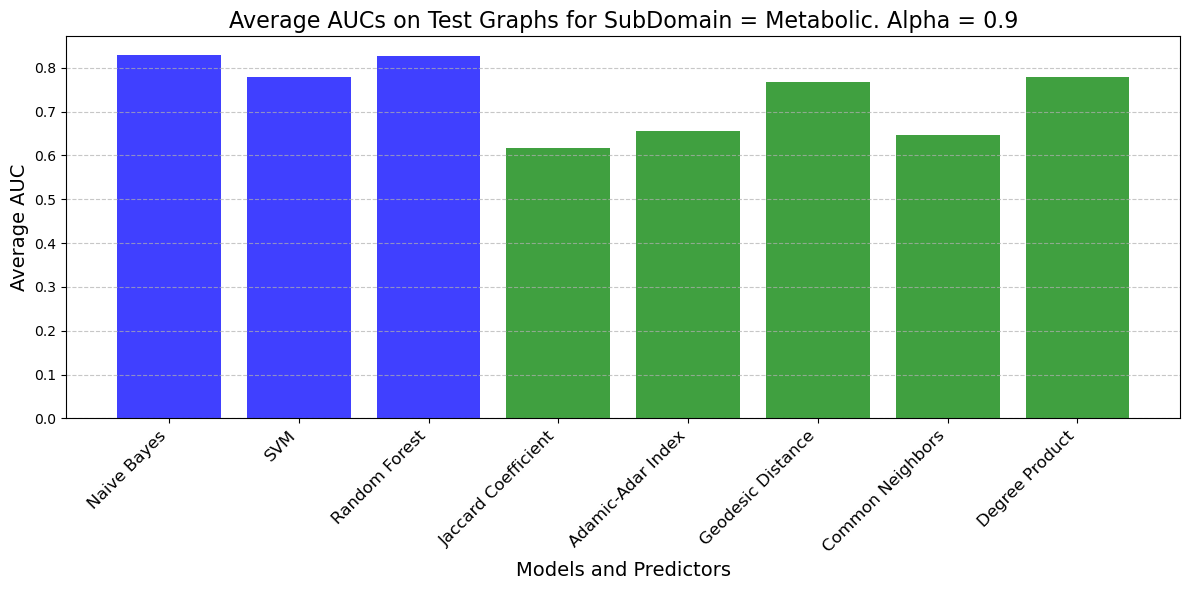

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_AUCs(average_AUCs, subDomain='Metabolic', alpha=0.9):
    """
    Plots a bar chart of the average AUCs for predictors and models.

    Parameters:
        average_AUCs (dict): Dictionary of average AUCs for predictors and models.
        subDomain (str): The subdomain for which the test graphs were evaluated.
    
    Returns:
        None
    """
    # Separate ML models and predictors
    ml_models = {k: v for k, v in average_AUCs.items() if k in ['Naive Bayes', 'SVM', 'Random Forest']}
    predictors = {k: v for k, v in average_AUCs.items() 
                  if k not in ml_models and not np.isnan(v)}
    
    # Combine names and values for plotting
    all_names = list(ml_models.keys()) + list(predictors.keys())
    all_values = list(ml_models.values()) + list(predictors.values())
    colors = ['blue'] * len(ml_models) + ['green'] * len(predictors)  # Different colors for ML models and predictors
    
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(all_names, all_values, color=colors, alpha=0.75)
    plt.xlabel('Models and Predictors', fontsize=14)
    plt.ylabel('Average AUC', fontsize=14)
    plt.title(f'Average AUCs on Test Graphs for SubDomain = {subDomain}. Alpha = {alpha}', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    title = f'Avg AUCs subDomain {subDomain} Alpha {alpha}'
    file_name = re.sub(r'[^\w\s-]', '_', title).replace(' ', '_') + ".png"
    plt.savefig(f'saved-figures/{file_name}')

    plt.show()


# # Example usage
# average_AUCs = {
#     'Naive Bayes': 0.8377898911053844,
#     'SVM': 0.7995101217501536,
#     'Random Forest': 0.8433849783990038,
#     'Jaccard Coefficient': 0.6582126270862714,
#     'Adamic-Adar Index': 0.6848095286668765,
#     'Geodesic Distance': 0.7846140030820298,
#     'Common Neighbors': 0.6865836339422625,
#     'Degree Product': 0.7995101217501536,
#     'Baseline': np.nan
# }

plot_average_AUCs(average_AUCs, subDomain='Metabolic', alpha=0.9)
